In [1]:
%matplotlib inline

In [2]:
from __future__ import division          # use // for integer division
from __future__ import absolute_import   # use from . import
from __future__ import print_function    # use print("...") instead of print "..."
from __future__ import unicode_literals  # all the strings are unicode

# Non-Separable 関数 と Covariance Matrix Adaptation

変数ごとに最適化することで最適解が得られる関数をSeparable関数と呼ぶ．前回までに用いたSphere関数やEllipsoid関数は，Separableでありwell-conditioned or ill-conditioned な関数であると言える．

今回は，Separableでない (Non-separableな) 関数の最適化について検討する．

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#### Ellipsoid 関数

In [4]:
EllipsoidCondition = 0
def ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    return np.sqrt(np.sum(w * x ** 2))

(-1.0, 1.0, -1.0, 1.0)

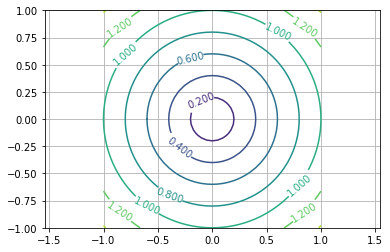

In [5]:
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-1, 1 + dy, dy), slice(-1, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = ellipsoid(np.array([x[i,j], y[i,j]]))
        
plt.figure()
CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.axis('equal')

#### 回転Ellipsoid関数 (回転座標変換後のEllipsoid関数)

In [6]:
# Orthogonalization
def gram_schmidt(mat):
    """Return a matrix whose row is orthonormalized"""
    R = mat.copy()
    for i in range(R.shape[0]):
        for j in range(i):
            R[i] = R[i] - np.dot(R[i], R[j]) * R[j]
        R[i] /= np.linalg.norm(R[i])
    return R

In [7]:
EllipsoidCondition = 1
N = 2

# Orthogonal Matrix (Rotation Matrix)
R = gram_schmidt(np.random.randn(N, N))

def rotated_ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    y = np.dot(R, x)
    return np.sqrt(np.sum(w * y ** 2))

(-1.0, 1.0, -1.0, 1.0)

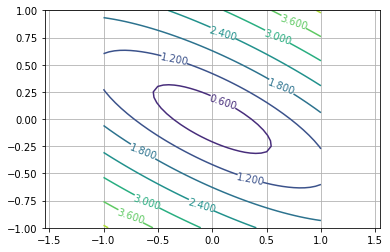

In [8]:
dx, dy = 0.05, 0.05
y, x = np.mgrid[slice(-1, 1 + dy, dy), slice(-1, 1 + dx, dx)]
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i,j] = rotated_ellipsoid(np.array([x[i,j], y[i,j]]))
        
plt.figure()
CS = plt.contour(x, y, z)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.axis('equal')

前回までに学んだCMAは，Separable CMAと呼ばれ，変数ごとの分散を学習する．

In [10]:
class SepCMAES(object):
    """SepCMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        self.D = np.ones(self.N)
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.cs = 4.0 / (self.N + 4.0)
        self.ds = 1.0 + self.cs
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        self.mueff = 1.0 / np.sum(self.weights**2)
        
        # For CMA
        self.cmu = self.mueff / (4 * self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arx = self.mean + self.sigma * np.random.normal(size=self.arx.shape) * np.sqrt(self.D)
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, (self.arx[idx] - self.mean)) / np.sqrt(self.D) / self.sigma
        # 共分散行列の対角要素を更新
        self.D = (1 - self.cmu) * self.D + self.cmu * np.dot(self.weights, (self.arx[idx] - self.mean) ** 2) / self.sigma ** 2
        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, (self.arx[idx] - self.mean))

回転Ellipsoid関数で実験

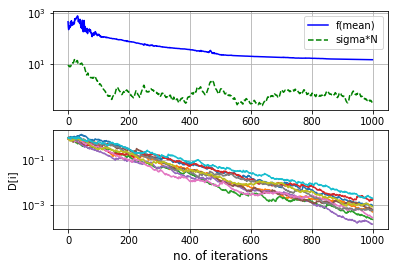

In [11]:
EllipsoidCondition = 6
N = 10
R = gram_schmidt(np.random.randn(N, N))
def rotated_ellipsoid(x):
    """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
    w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
    y = np.dot(R, x)
    return np.sqrt(np.sum(w * y ** 2))

es = SepCMAES(func=rotated_ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    diagC[i] = es.D
    
plt.subplot(211)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(212)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()

条件数を変えて収束曲線を比較

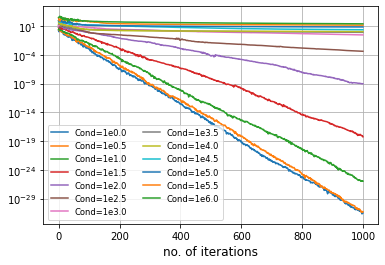

In [12]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10
    R = gram_schmidt(np.random.randn(N, N))
    def rotated_ellipsoid(x):
        """ベクトルの二乗要素の加重和．最適解は(0,...,0)"""
        w = np.logspace(0, EllipsoidCondition, base=10, num=x.shape[0], endpoint=True)
        y = np.dot(R, x)
        return np.sqrt(np.sum(w * y ** 2))

    es = SepCMAES(func=rotated_ellipsoid,    
               init_mean=np.zeros(10), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)

観察される結果

* 条件数が大きくなると収束速度が著しく低下する
* CSA-ESと変わらない

原因

* 変数ごとの分散しか学習していない ==> 解生成分布は座標軸に沿った楕円形
* 等高線(楕円)が座標軸に沿っていない(回転している)場合，上記の弱点により優れた解を生成することができない

#### 共分散行列の更新 (変数間依存性を考慮)

アイディア: 解生成分布が(座標系に依存しない)任意の楕円形を取れるように，共分散行列($N \times N$ 正定値対称行列)を学習する．

In [13]:
class CMAES(object):
    """CMA Evolution Strategy with CSA"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.D = np.ones(self.N) # 共分散行列の固有値
        self.B = np.eye(self.N)  # 共分散行列の固有ベクトル
        self.C = np.dot(self.B * self.D, self.B.T) # 共分散行列
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
        
        # For CSA
        self.ps = np.zeros(self.N)
        self.mueff = 1.0 / np.sum(self.weights**2)
        self.cs = (2.0 + self.mueff) / (self.N + 3.0 + self.mueff)
        self.ds = 1.0 + self.cs + max(1.0, np.sqrt(self.mueff / self.N))
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))
        
        # For CMA
        self.cmu = self.mueff / (self.N ** 2 / 2 + self.N + self.mueff)
        
    def sample(self):
        """候補解を生成する．"""
        self.arz = np.random.normal(size=self.arx.shape)
        self.ary = np.dot(np.dot(self.arz, self.B) * np.sqrt(self.D), self.B.T)
        self.arx = self.mean + self.sigma * self.ary
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_param(self):
        """パラメータを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        # 進化パスの更新 (平均ベクトル移動量の蓄積)
        self.ps = (1 - self.cs) * self.ps + np.sqrt(self.cs * (2 - self.cs) * self.mueff) * np.dot(self.weights, self.arz[idx])
        # 共分散行列の更新
        self.C = (1 - self.cmu) * self.C + self.cmu * np.dot(self.ary[idx].T * self.weights, self.ary[idx])
        # 共分散行列の固有値分解
        self.D, self.B = np.linalg.eigh(self.C)

        # 進化パスの長さが，ランダム関数の下での期待値よりも大きければステップサイズを大きくする．
        self.sigma = self.sigma * np.exp(self.cs / self.ds * (np.linalg.norm(self.ps) / self.chiN - 1))        
        self.mean += np.dot(self.weights, self.arx[idx] - self.mean)

rotated Ellipsoidでの振る舞い

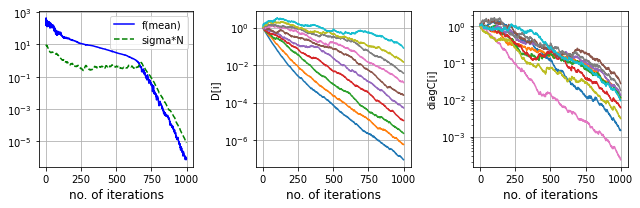

In [14]:
EllipsoidCondition = 6
N = 10
R = gram_schmidt(np.random.randn(N, N))

es = CMAES(func=rotated_ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

separable Ellipsoidでの振る舞い

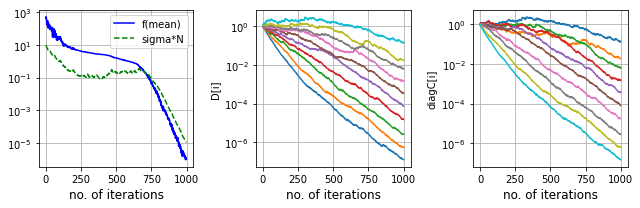

In [15]:
EllipsoidCondition = 6

es = CMAES(func=ellipsoid,            
           init_mean=np.zeros(10),  
           init_sigma=1, 
           nsample=10)             

maxiter = 1000
mean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
D = np.zeros((maxiter, es.N)) * np.nan
diagC = np.zeros((maxiter, es.N)) * np.nan

for i in range(maxiter):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    sigmaN[i] = es.sigma * es.N
    D[i] = es.D
    diagC[i] = np.diag(es.C)

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.semilogy(mean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best')
plt.subplot(132)
plt.semilogy(D)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('D[i]')
plt.grid()
plt.subplot(133)
plt.semilogy(diagC)
plt.xlabel('no. of iterations', fontsize='large')
plt.ylabel('diagC[i]')
plt.grid()
plt.tight_layout()

* Separable Ellipsoid と Rotated Ellipsoid で，固有値の振る舞いが変わらない．
* 共分散行列の対角要素をみると大きく異なる

#### separable Ellipsoid と rotated Ellipsoid の比較

Text(0.5, 1.0, 'rotated ellipsoid')

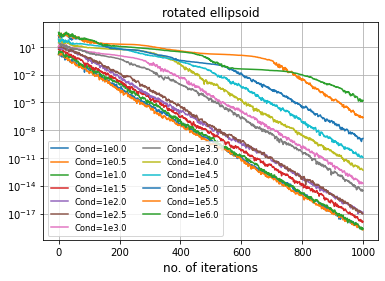

In [16]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10
    R = gram_schmidt(np.random.randn(N, N))
    es = CMAES(func=rotated_ellipsoid,    
               init_mean=np.zeros(10), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)
plt.title('rotated ellipsoid')

Text(0.5, 1.0, 'separable ellipsoid')

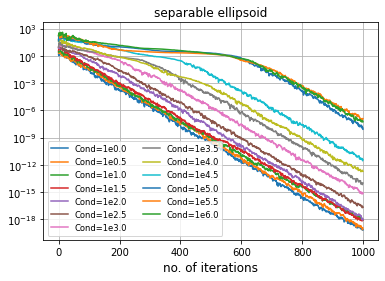

In [17]:
EllCondArray = np.linspace(0, 6, num=13, endpoint=True)
for j in range(EllCondArray.shape[0]):
    EllipsoidCondition = EllCondArray[j]
    N = 10

    es = CMAES(func=ellipsoid,    
               init_mean=np.zeros(N), 
               init_sigma=1,
               nsample=10)                 

    maxiter = 1000
    mean = np.zeros(maxiter) * np.nan
    sigmaN = np.zeros(maxiter) * np.nan
    for i in range(maxiter):
        es.sample()
        es.evaluate()
        es.update_param()
        mean[i] = es.func(es.mean)
        sigmaN[i] = es.sigma * es.N
    
    plt.semilogy(mean, label='Cond=1e'+str(EllipsoidCondition))

plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend(loc='best', fontsize='small', ncol=2)
plt.title('separable ellipsoid')